In [1]:
import yfinance as yf
import pandas as pd
import backtrader as bt
import math




In [2]:
# Download SPY data
data = yf.download('SPY', start='1993-01-01', end='2020-02-16')
data.head()




[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,SPY,SPY,SPY,SPY,SPY,SPY
Date,,,,,,
1993-01-29 00:00:00+00:00,24.608624,43.93750,43.96875,43.75000,43.96875,1003200
1993-02-01 00:00:00+00:00,24.783644,44.25000,44.25000,43.96875,43.96875,480500
1993-02-02 00:00:00+00:00,24.836164,44.34375,44.37500,44.12500,44.21875,201300
1993-02-03 00:00:00+00:00,25.098692,44.81250,44.84375,44.37500,44.40625,529400
1993-02-04 00:00:00+00:00,25.203720,45.00000,45.09375,44.46875,44.96875,531500


In [3]:
# Get Rid of ticker columnn
if isinstance(data.columns, pd.MultiIndex):
    # Flatten the MultiIndex by using the second level as column names
    data.columns = data.columns.get_level_values(0)
    data.head()



In [4]:
# Resetting the index (so that date column is in the proper place)
data.reset_index(inplace=True)
data.head()


Price,Date,Adj Close,Close,High,Low,Open,Volume
0,1993-01-29 00:00:00+00:00,24.608624,43.93750,43.96875,43.75000,43.96875,1003200
1,1993-02-01 00:00:00+00:00,24.783644,44.25000,44.25000,43.96875,43.96875,480500
2,1993-02-02 00:00:00+00:00,24.836164,44.34375,44.37500,44.12500,44.21875,201300
3,1993-02-03 00:00:00+00:00,25.098692,44.81250,44.84375,44.37500,44.40625,529400
4,1993-02-04 00:00:00+00:00,25.203720,45.00000,45.09375,44.46875,44.96875,531500


In [5]:
# Reorder the columns to match the desired order
data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
data.head()


Price,Date,Open,High,Low,Close,Volume
0,1993-01-29 00:00:00+00:00,43.96875,43.96875,43.75000,43.93750,1003200
1,1993-02-01 00:00:00+00:00,43.96875,44.25000,43.96875,44.25000,480500
2,1993-02-02 00:00:00+00:00,44.21875,44.37500,44.12500,44.34375,201300
3,1993-02-03 00:00:00+00:00,44.40625,44.84375,44.37500,44.81250,529400
4,1993-02-04 00:00:00+00:00,44.96875,45.09375,44.46875,45.00000,531500


In [6]:
class GoldenCross(bt.Strategy):
    params = (('fast',50),('slow',200), ('order_percentage',0.95),('ticker', 'SPY'))
    
    #initialize indicators
    def __init__(self):
        #50-day moving average
        self.fast_moving_average = bt.indicators.SMA(
            self.data.close, period = self.params.fast, plotname = '50 day moving average'
        )
        
        #200-day moving average
        self.slow_moving_average = bt.indicators.SMA(
            self.data.close, period =self.params.slow, plotname='200 day moving average'
        )
       
        #Crossover indicator                      50-ma crosses above 200-ma
        self.crossover =bt.indicators.CrossOver(self.fast_moving_average, self.slow_moving_average)
    
    def next(self):
        # If faster ma crosses upward
        # check position size
        if self.position.size == 0:
            if self.crossover > 0:
                # only buy up to 95% of portfolio
                amount_to_invest = (self.params.order_percentage * self.broker.cash)
                #share size
                self.size = math.floor(amount_to_invest / self.data.close)
                
                # closing price of the the current bar: self.data.close[0]
                print(f"Buy {self.size} shares of {self.params.ticker} at {self.data.close[0]}")

                #buy
                self.buy(size=self.size)
        
        # If faster ma crosses downward
        if self.position.size >0:
            if self.crossover < 0:
                
                print(f"Sell {self.size} shares of {self.params.ticker} at {self.data.close[0]}")
                self.close()


In [7]:


parsed_data= bt.feeds.PandasData(dataname=data, 
    datetime='Date',  # Name of the Date column
    open='Open',      # Name of the Open column
    high='High',      # Name of the High column
    low='Low',        # Name of the Low column
    close='Close',# Name of the Adjusted Close column
    volume='Volume',  # Name of the Volume column
    openinterest=-1)



In [8]:
cerebro= bt.Cerebro()
cerebro.broker.setcash(10000)



In [9]:
cerebro.adddata(parsed_data)

cerebro.addstrategy(GoldenCross)

0

Buy 201 shares of SPY at 47.046875
Sell 201 shares of SPY at 104.9375
Buy 171 shares of SPY at 118.40625
Sell 171 shares of SPY at 136.53125
Buy 169 shares of SPY at 138.5
Sell 169 shares of SPY at 140.53125
Buy 250 shares of SPY at 95.11000061035156
Sell 250 shares of SPY at 110.02999877929688
Buy 232 shares of SPY at 117.27999877929688
Sell 232 shares of SPY at 125.69000244140625
Buy 224 shares of SPY at 130.41000366210938
Sell 224 shares of SPY at 148.1300048828125
Buy 371 shares of SPY at 89.3499984741211
Sell 371 shares of SPY at 102.87000274658203
Buy 319 shares of SPY at 118.3499984741211
Sell 319 shares of SPY at 118.12000274658203
Buy 287 shares of SPY at 131.32000732421875
Sell 287 shares of SPY at 199.27999877929688
Buy 272 shares of SPY at 204.86000061035156
Sell 272 shares of SPY at 192.11000061035156
Buy 256 shares of SPY at 208.61000061035156
Sell 256 shares of SPY at 263.57000732421875
Buy 233 shares of SPY at 285.8299865722656


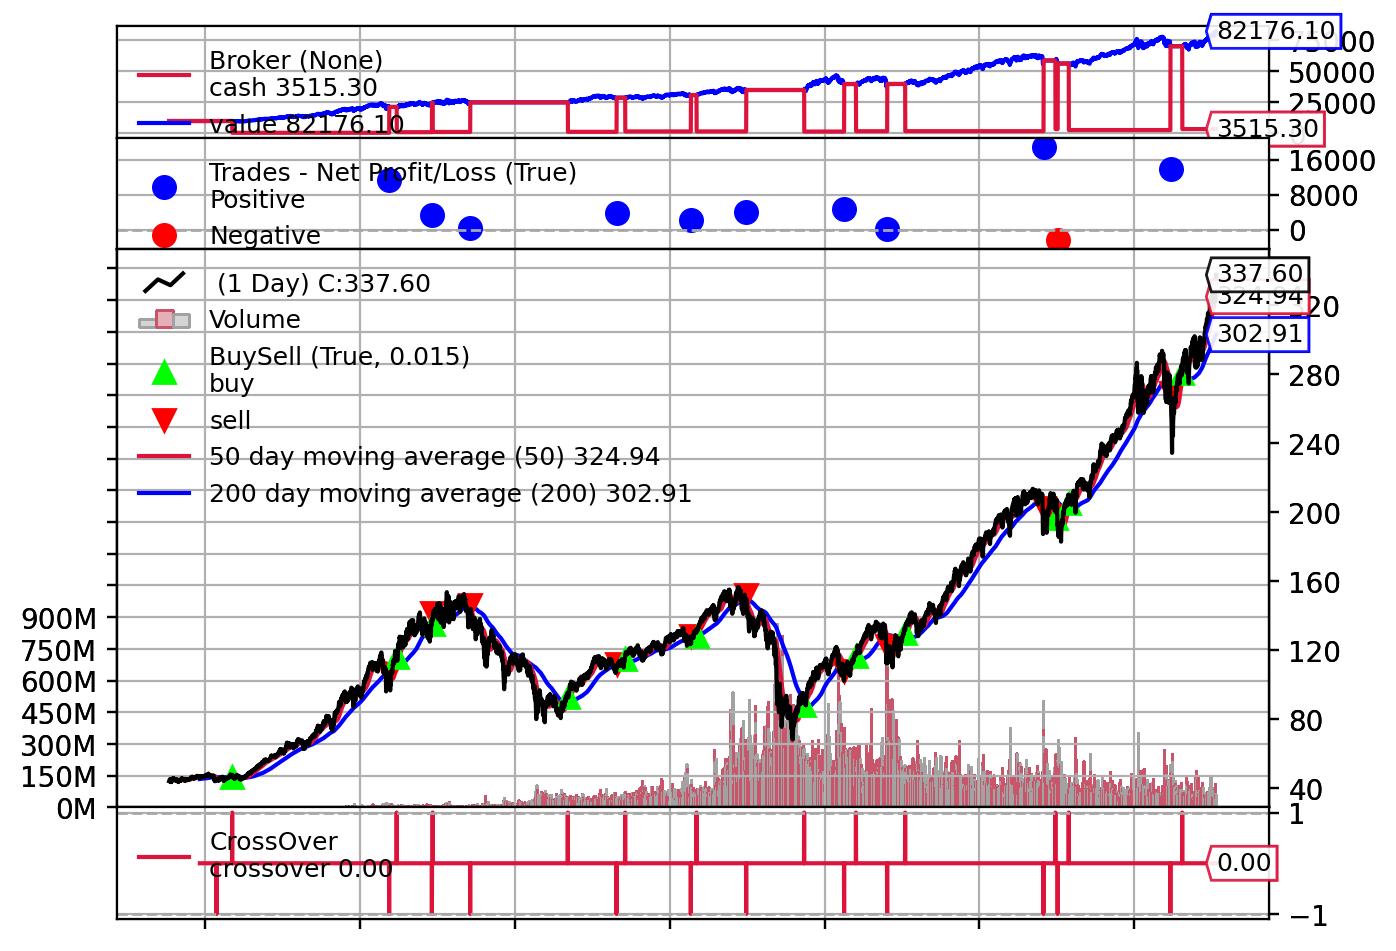

[[<Figure size 1280x960 with 10 Axes>]]

In [11]:
cerebro.run()
%matplotlib inline

cerebro.plot(iplot=False)